In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from time import time

import visuals as vs

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('sphist.csv')

df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [3]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [4]:
df["Date"] = pd.to_datetime(df["Date"])

df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
Adj Close           float64
dtype: object

In [5]:
# Sort data in descending order

df = df.sort_values(by='Date')

df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


## Generating Indicators to assist in making accurate predictions

In [6]:
# Average price of the past 5, 30 and 365 days
day_5 = df["Close"].rolling(5).mean().shift(1)
day_30 = df["Close"].rolling(30).mean().shift(1)
day_365 = df["Close"].rolling(365).mean().shift(1)

# Ratio of the past 5 to 365 days
ratio_5_to_365 = day_5 / day_365

# Standard deviation of the past 5 and 365 days
day_5_std = df["Close"].rolling(5).std().shift(1)
day_365_std = df["Close"].rolling(365).std().shift(1)

# Ratio of the standard deviation of the past 5 to 365 days
ratio_std_5_to_365 = day_5_std / day_365_std

# Add to main dataframe

df['day_5'] = day_5
df['day_30'] = day_30
df['day_365'] = day_365
df['ratio_5_to_365'] = ratio_5_to_365
df['day_5_std'] = day_5_std
df['day_365_std'] = day_365_std
df['ratio_std_5_to_365'] = ratio_std_5_to_365

## Training the Algorithm

In [7]:
# def train_test(df, features, model):
#     df = df.dropna(axis=0)
    
#     train = df[df["Date"] < datetime(year=2013, month=1, day=1)]
#     test = df[df["Date"] >= datetime(year=2013, month=1, day=1)]

#     model.fit(train[features], train['Close'])

#     predictions = model.predict(test[features])

#     mae = mean_absolute_error(test['Close'], predictions)

#     mse = mean_squared_error(test['Close'], predictions)
#     rmse = np.sqrt(mse)
    
#     return rmse, mae

16.145140609743716
22.201870066394005
Feature: day_5, Score: 1.06687
Feature: day_30, Score: -0.06463
Feature: day_365, Score: -0.00253
Feature: ratio_5_to_365, Score: -0.66069
Feature: day_5_std, Score: -0.11151
Feature: day_365_std, Score: 0.01752
Feature: ratio_std_5_to_365, Score: 0.94158


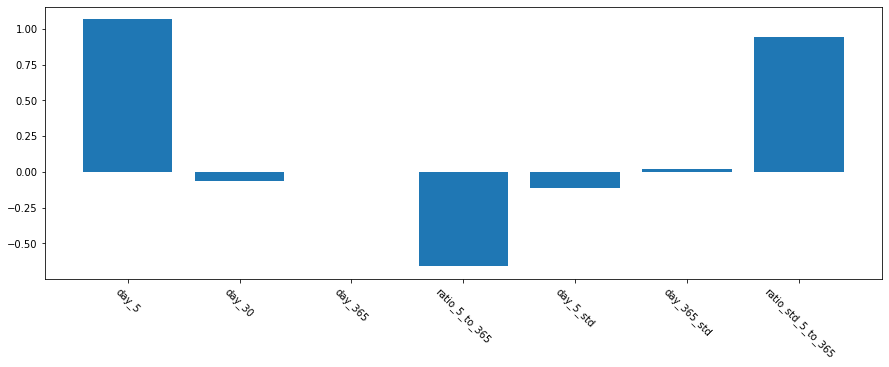

In [11]:
features = ['day_5', 'day_30', 'day_365', 'ratio_5_to_365', 'day_5_std', 'day_365_std', 'ratio_std_5_to_365']

lr = LinearRegression()

lr = train_test(df, features, lr)

importance_1 = lr.coef_

for i,v in enumerate(importance_1):
    print('Feature: %s, Score: %.5f' % (features[i],v))
# plot feature importance
fig = plt.figure(figsize = (15,5))
plt.bar(features, importance_1)
plt.xticks(rotation=-45)
plt.show()

# Try different algorithms

In [24]:
features = ['day_5', 'day_30', 'day_365', 'ratio_5_to_365', 'day_5_std', 'day_365_std', 'ratio_std_5_to_365']

df = df.dropna(axis=0)

train = df[df["Date"] < datetime(year=2013, month=1, day=1)]
test = df[df["Date"] >= datetime(year=2013, month=1, day=1)]

x_train = train[features]
y_train = train["Close"]

x_test = test[features]
y_test = test["Close"]

def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test)
    # then get predictions on the training set
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute rmse on train set
    mse_train = mean_squared_error(y_train,predictions_train)
    results['rmse_train'] = np.sqrt(mse_train)
        
    # Compute rmse on test set
    mse_test = mean_squared_error(y_test, predictions_test)
    results['rmse_test'] = np.sqrt(mse_test)
    
    # Compute mae on train set
    results['mae_train'] = mean_absolute_error(y_train,predictions_train)
        
    # Compute mae on test set
    results['mae_test'] = mean_absolute_error(y_test, predictions_test)
       
    # Success
    print("{} has been trained".format(learner.__class__.__name__))
        
    # Return the results
    return results

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor trained on


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR trained on
LinearRegression trained on


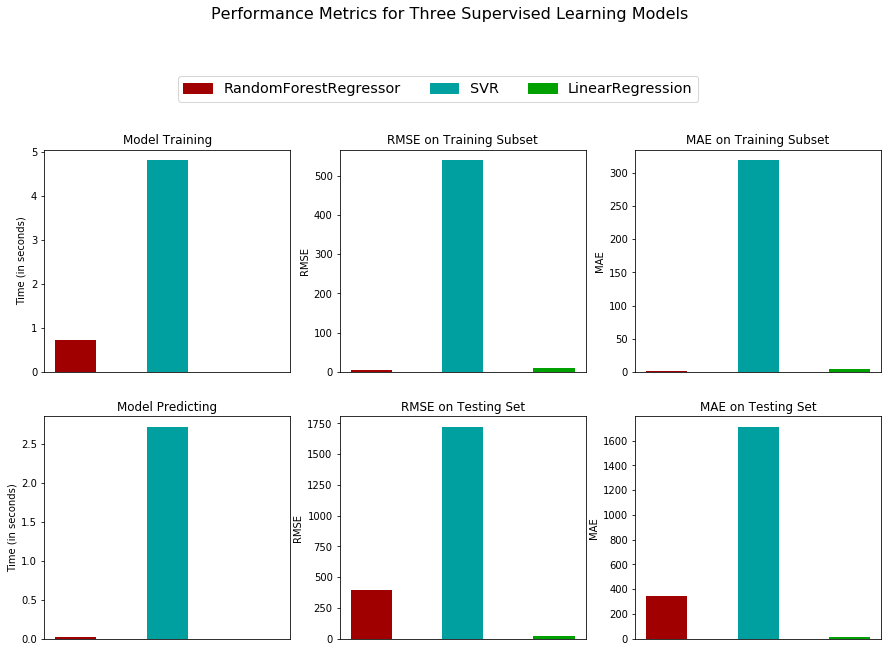

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

reg_A = RandomForestRegressor(random_state=42)
reg_B = SVR()
reg_C = LinearRegression()

# Collect results on the learners
results = {}
for reg in [reg_A, reg_B, reg_C]:
    reg_name = reg.__class__.__name__
    results[reg_name] = train_predict(reg, x_train, y_train, x_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
# evaluate(results)
vs.evaluate(results)

In [97]:
for k, learner in enumerate(results.keys()):
    
    for j, metric in enumerate(['train_time', 'rmse_train', 'mae_train', 'pred_time', 'rmse_test', 'mae_test']):
        print(learner)
        print(metric)
        print(results[learner][metric])
            
            

RandomForestRegressor
train_time
0.7314369678497314
RandomForestRegressor
rmse_train
4.267725871964632
RandomForestRegressor
mae_train
1.8067387227043787
RandomForestRegressor
pred_time
0.01799488067626953
RandomForestRegressor
rmse_test
393.61729912609303
RandomForestRegressor
mae_test
347.1108248713128
SVR
train_time
5.190373182296753
SVR
rmse_train
539.7494641409335
SVR
mae_train
318.93655164870626
SVR
pred_time
2.7885642051696777
SVR
rmse_test
1720.6288853726724
SVR
mae_test
1709.853749834377
LinearRegression
train_time
0.0027761459350585938
LinearRegression
rmse_train
10.425846061148702
LinearRegression
mae_train
4.979250385436803
LinearRegression
pred_time
0.000982046127319336
LinearRegression
rmse_test
22.201870066394005
LinearRegression
mae_test
16.145140609743716


In [9]:
# Average volume of the past 5, 30 and 365 days
volume_5 = df["Volume"].rolling(5).mean().shift(1)
volume_30 = df["Volume"].rolling(30).mean().shift(1)
volume_365 = df["Volume"].rolling(365).mean().shift(1)

# Ratio of the past 5 to 365 days
volume_5_to_365 = volume_5 / volume_365

# Standard deviation of the past 5 and 365 days
volume_5_std = df["Volume"].rolling(5).std().shift(1)
volume_365_std = df["Volume"].rolling(365).std().shift(1)

# Ratio of the standard deviation of the past 5 to 365 days
volume_std_5_to_365 = volume_5_std / volume_365_std

# Add to main dataframe

df['volume_5'] = volume_5
df['volume_30'] = volume_30
df['volume_365'] = volume_365
df['volume_5_to_365'] = volume_5_to_365
df['volume_5_std'] = volume_5_std
df['volume_365_std'] = volume_365_std
df['volume_std_5_to_365'] = volume_std_5_to_365

In [98]:
features_updated = ['day_5', 'day_30', 'day_365', 'ratio_5_to_365', 'day_5_std', 'day_365_std', 'ratio_std_5_to_365',
           'volume_5', 'volume_30', 'volume_365', 'volume_5_to_365', 'volume_5_std',
            'volume_365_std', 'volume_std_5_to_365']

lr = train_test(df, features_updated)

importance = lr.coef_

for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (features_updated[i],v))
# plot feature importance
fig = plt.figure(figsize = (15,5))
plt.bar(features_updated, importance)
plt.xticks(rotation=-45)
plt.show()

KeyError: "['volume_5', 'volume_365_std', 'volume_30', 'volume_std_5_to_365', 'volume_5_to_365', 'volume_5_std', 'volume_365'] not in index"

In [ ]:
# print(test.shape)

In [ ]:
# plt.plot(test['Date'], test['Close'], label='True Price')
# plt.plot(test['Date'], predictions, label='Predicted Price')

# plt.xticks(rotation=-45)

# plt.legend()
# plt.show()

In [ ]:
# def feature_plot(importances, X_train, y_train):
    
#     # Display the five most important features
#     indices = np.argsort(importances)[::-1]
#     columns = X_train.columns.values[indices[:5]]
#     values = importances[indices][:5]

#     # Creat the plot
#     fig = plt.figure(figsize = (9,5))
#     plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
#     plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
#           label = "Feature Weight")
#     plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
#           label = "Cumulative Feature Weight")
#     plt.xticks(np.arange(5), columns)
#     plt.xlim((-0.5, 4.5))
#     plt.ylabel("Weight", fontsize = 12)
#     plt.xlabel("Feature", fontsize = 12)
    
#     plt.legend(loc = 'upper center')
#     plt.tight_layout()
#     plt.show()  

In [ ]:
# TODO: interpret and see what it means

importance = lr.coef_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar(features, importance)
plt.xticks(rotation=-45)
plt.show()

# Plot
# feature_plot(importances, train[features], train["Close"])

In [ ]:
test_dates = df[df["Date"] >= datetime(year=2013, month=1, day=1)]["Date"]

print(test_dates)

In [ ]:
def train_test(df, features, date):
    train_df  = df[df["Date"] < date]
    test_df = df[df["Date"] == date]
    
    #initialize model
    lr = LinearRegression()
    target = 'Close'

    #Train
    lr.fit(train_df[features], train_df[target])

    #Test
    prediction = lr.predict(test_df[features])
    
    mae = mean_absolute_error(test_df[target], prediction)
#     mse = mean_squared_error(test[target], prediction)
#     rmse = np.sqrt(mse)
    return mae

In [ ]:
maes = test_dates.apply(lambda date: train_test(df,features,date))

In [ ]:
mae = np.mean(maes)

# mse = np.sqrt(mse)

mae

In [ ]:
# plt.plot(test['Date'], test['Close'], label='True Price')
# plt.plot(test['Date'], predictions, label='Predicted Price')

# plt.xticks(rotation=-45)

# plt.legend()
# plt.show()